In [33]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import sklearn as skl
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns 

# Prédiction des variables 'SiteEnergyUse(kBtu)' et 'TotalGHGEmissions'

In [34]:
df = pd.read_csv('building-energy-benchmarking_final_features.csv',sep=',')
df = df.drop(df.columns[[0]], axis=1) 
df.dropna(inplace = True)
df.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1411 entries, 0 to 2051
Data columns (total 23 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   OSEBuildingID              1411 non-null   int64  
 1   DataYear                   1411 non-null   int64  
 2   BuildingType               1411 non-null   int64  
 3   PrimaryPropertyType        1411 non-null   int64  
 4   YearBuilt                  1411 non-null   int64  
 5   NumberofBuildings          1411 non-null   float64
 6   NumberofFloors             1411 non-null   float64
 7   PropertyGFATotal           1411 non-null   int64  
 8   PropertyGFAParking         1411 non-null   int64  
 9   PropertyGFABuilding(s)     1411 non-null   int64  
 10  LargestPropertyUseTypeGFA  1411 non-null   float64
 11  ENERGYSTARScore            1411 non-null   float64
 12  SiteEUI(kBtu/sf)           1411 non-null   float64
 13  SourceEUI(kBtu/sf)         1411 non-null   float

In [35]:
df = df.drop(df.columns[[0,20,21,22]],axis = 1)
df.info(verbose = True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1411 entries, 0 to 2051
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   DataYear                   1411 non-null   int64  
 1   BuildingType               1411 non-null   int64  
 2   PrimaryPropertyType        1411 non-null   int64  
 3   YearBuilt                  1411 non-null   int64  
 4   NumberofBuildings          1411 non-null   float64
 5   NumberofFloors             1411 non-null   float64
 6   PropertyGFATotal           1411 non-null   int64  
 7   PropertyGFAParking         1411 non-null   int64  
 8   PropertyGFABuilding(s)     1411 non-null   int64  
 9   LargestPropertyUseTypeGFA  1411 non-null   float64
 10  ENERGYSTARScore            1411 non-null   float64
 11  SiteEUI(kBtu/sf)           1411 non-null   float64
 12  SourceEUI(kBtu/sf)         1411 non-null   float64
 13  SiteEnergyUse(kBtu)        1411 non-null   float

### Observation des densités des variables à prédire

Text(0.5, 1.0, 'distribution de la variable SiteEnergyUse(kBtu)')

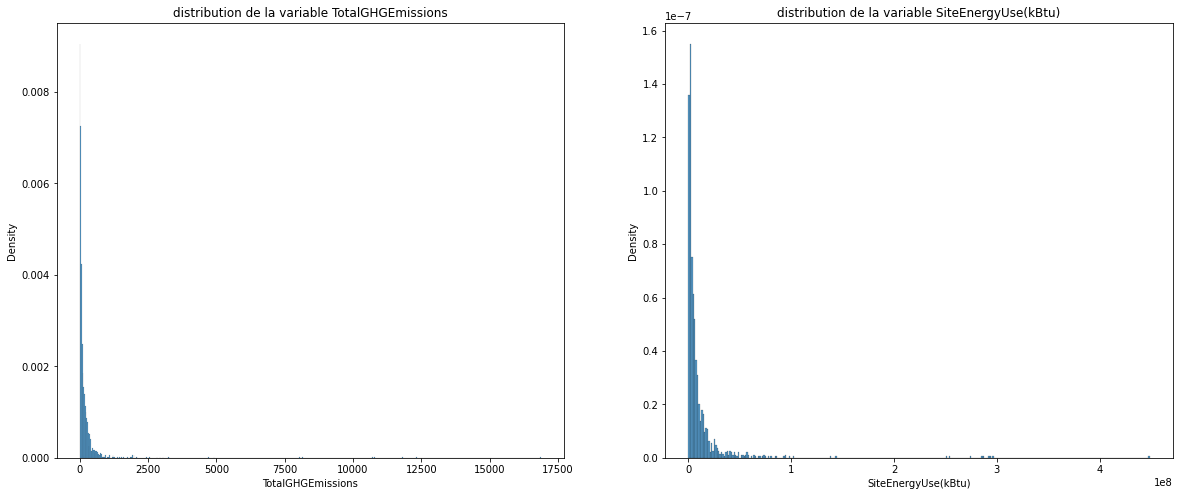

In [36]:
fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20,8))

sns.histplot(data=df, x='TotalGHGEmissions', stat="density",ax = axes[0])
sns.histplot(data=df, x='SiteEnergyUse(kBtu)', stat="density",ax =axes[1])
axes[0].set_title('distribution de la variable TotalGHGEmissions')
axes[1].set_title('distribution de la variable SiteEnergyUse(kBtu)')

#### On observe que les deux variables à prédire suivent une distribution exponentielle. 
On utilise la fonction inverse afin d'obtenir une distribution normale

In [37]:
from sklearn.preprocessing import FunctionTransformer

logtransformer = FunctionTransformer(np.log, inverse_func = np.exp, check_inverse = True)


### Separation des données 

In [57]:
targets_columns = ['SiteEnergyUse(kBtu)','TotalGHGEmissions']
df_features = df.copy()
df_targets = df.copy()
df_features = df_features.drop(columns=['SiteEnergyUse(kBtu)', 'TotalGHGEmissions','ENERGYSTARScore'])
df_target_elec = df_targets['SiteEnergyUse(kBtu)']
df_target_CO2 = df_targets['TotalGHGEmissions']
df_target_CO2.head()

0     249.43
1     263.51
2    2061.48
3    1936.34
4     507.70
Name: TotalGHGEmissions, dtype: float64

### Standardisation des données

Text(0.5, 1.0, 'application de la fonction inverse sur la distribution de la variable SiteEnergyUse(kBtu)')

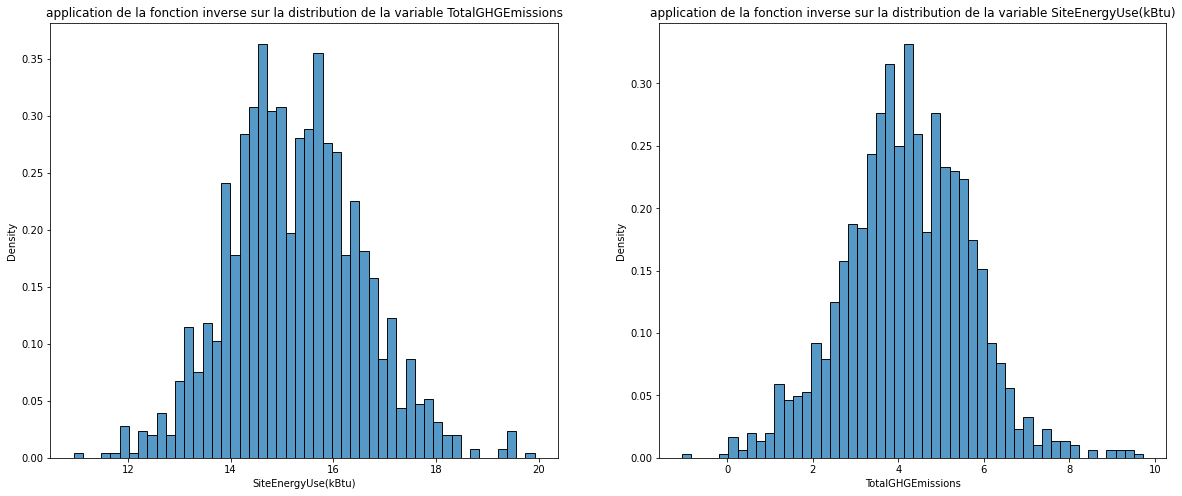

In [60]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df_features = scaler.fit_transform(df_features)

target_e = logtransformer.transform(df_target_elec)
target_C = logtransformer.transform(df_target_CO2)

# df_features_tr = scaler.transform(df_features)

fig, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(20,8))

sns.histplot(data=target_e, stat="density",bins = 50,ax = axes[0])
sns.histplot(data=target_C, stat="density",bins = 50 ,ax =axes[1])
axes[0].set_title('application de la fonction inverse sur la distribution de la variable TotalGHGEmissions')
axes[1].set_title('application de la fonction inverse sur la distribution de la variable SiteEnergyUse(kBtu)')

### Creation des datasets 

In [61]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import utils

(Xtrain_e,ytrain_e,Xtest_e,ytest_e) = train_test_split(df_features, target_e)
(Xtrain_g,ytrain_g,Xtest_g,ytest_g) = train_test_split(df_features, target_C)

lab_enc = preprocessing.LabelEncoder()
df_target_elec = lab_enc.fit_transform(target_e)
df_target_CO2 = lab_enc.fit_transform(target_C)

print(utils.multiclass.type_of_target(target_e))
print(utils.multiclass.type_of_target(target_e.astype('int')))
print(utils.multiclass.type_of_target(df_target_elec))

print(utils.multiclass.type_of_target(target_C))
print(utils.multiclass.type_of_target(target_C.astype('int')))
print(utils.multiclass.type_of_target(df_target_CO2))

continuous
multiclass
multiclass
continuous
multiclass
multiclass


# Prédictions sur les différents modèles

In [101]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn import linear_model
reg = linear_model.LinearRegression()

scores_elec1 = cross_validate(reg, df_features, df_target_elec, cv=5, scoring = ('r2','neg_mean_absolute_error'))
print('prediction en électricité avec le modèle linear regression : \n',scores_elec1)

scores_CO21 = cross_validate(reg, df_features, df_target_CO2, cv = 5,scoring = ('r2','neg_mean_absolute_error'))
print('prédiction en consomation de CO2 avec le modèle linear regression : \n', scores_CO21)

prediction en électricité avec le modèle linear regression : 
 {'fit_time': array([0.00299311, 0.00199389, 0.00199485, 0.00199437, 0.00298977]), 'score_time': array([0.        , 0.00099754, 0.00099707, 0.00199747, 0.        ]), 'test_r2': array([0.31313953, 0.54550927, 0.48014983, 0.14628649, 0.07667341]), 'test_neg_mean_absolute_error': array([-251.53004236, -216.30227524, -237.98242245, -268.5925088 ,
       -320.86599579])}
prédiction en consomation de CO2 avec le modèle linear regression : 
 {'fit_time': array([0.00398588, 0.00278759, 0.00199771, 0.00233173, 0.00215077]), 'score_time': array([0.00099874, 0.        , 0.00099659, 0.        , 0.        ]), 'test_r2': array([0.10882096, 0.5528434 , 0.24283266, 0.41668489, 0.16166613]), 'test_neg_mean_absolute_error': array([-249.76879564, -199.51640209, -250.67778023, -215.64537281,
       -276.74969545])}


### Cross validation sur le modèle linéaire SVR

In [91]:
from sklearn.svm import SVR

clf_svr = SVR()
scores_elec2 = cross_validate(clf_svr, df_features, df_target_elec, cv=5, scoring = ('r2','neg_mean_absolute_error'))
print('prediction en électricité avec le modèle SVR : \n',scores_elec2)

scores_CO22 = cross_validate(clf_svr, df_features, df_target_CO2, cv = 5,scoring = ('r2','neg_mean_absolute_error'))
print('prédiction en consomation de CO2 avec le modèle SVR : \n', scores_CO22)

prediction en électricité avec le modèle SVR : 
 {'fit_time': array([0.06283212, 0.05983973, 0.05186033, 0.05186439, 0.04883385]), 'score_time': array([0.03790069, 0.04092479, 0.03789639, 0.03789783, 0.03889608]), 'test_r2': array([-0.10496656,  0.22195733,  0.21609327, -0.00847527, -0.56542483]), 'test_neg_mean_absolute_error': array([-323.37255041, -294.24823362, -308.7064556 , -304.36400114,
       -417.59222244])}
prédiction en consomation de CO2 avec le modèle SVR : 
 {'fit_time': array([0.04990077, 0.05186582, 0.05584979, 0.04887128, 0.04887009]), 'score_time': array([0.04188919, 0.03889155, 0.03989315, 0.03590393, 0.03789783]), 'test_r2': array([-0.07321078,  0.16341949,  0.17904257,  0.18947048, -0.29518319]), 'test_neg_mean_absolute_error': array([-325.98260739, -277.80177432, -327.93222986, -274.69968387,
       -361.69868097])}


### Cross validation modèle linéaire ElasticNet

In [92]:
from sklearn.linear_model import ElasticNet 

clf = ElasticNet()
scores_elec3 = cross_validate(clf, df_features, target_e, cv=5, scoring = ('r2','neg_mean_absolute_error'))
print('prediction en électricité avec le modèle ElasticNet : \n',scores_elec3)

scores_CO23 = cross_validate(clf, df_features, target_C, cv = 5,scoring = ('r2','neg_mean_absolute_error'))
print('prédiction en consomation de CO2 avec le modèle ElasticNet : \n', scores_CO23)

prediction en électricité avec le modèle ElasticNet : 
 {'fit_time': array([0.00299025, 0.00199389, 0.00299335, 0.00198913, 0.00170183]), 'score_time': array([0.00099778, 0.00099611, 0.00099802, 0.00102973, 0.        ]), 'test_r2': array([ 0.11248027,  0.31728912,  0.29616615,  0.18023597, -0.27497097]), 'test_neg_mean_absolute_error': array([-0.89437322, -0.80269734, -0.87337623, -0.83374765, -1.13565086])}
prédiction en consomation de CO2 avec le modèle ElasticNet : 
 {'fit_time': array([0.00193334, 0.00199628, 0.00095987, 0.00233984, 0.00214601]), 'score_time': array([0.        , 0.        , 0.00103426, 0.        , 0.        ]), 'test_r2': array([ 0.06545028,  0.26538419,  0.24367298,  0.26054555, -0.09189694]), 'test_neg_mean_absolute_error': array([-1.04713937, -0.8594757 , -1.09395287, -0.83253768, -1.19743685])}


### Cross validation sur modèle non inéaire random forest

In [93]:
from sklearn.ensemble import RandomForestRegressor
regr = RandomForestRegressor()

scores_elec4 = cross_validate(regr, df_features, df_target_elec, cv=5, scoring = ('r2','neg_mean_absolute_error'))
print('prediction en électricité avec le modèle RandomForest : \n',scores_elec4)

scores_CO24 = cross_validate(regr, df_features, df_target_CO2, cv = 5,scoring = ('r2','neg_mean_absolute_error'))
print('prédiction en consomation de CO2 avec le modèle RandomForest : \n', scores_CO24)

prediction en électricité avec le modèle RandomForest : 
 {'fit_time': array([0.50540304, 0.48010945, 0.52255416, 0.48120666, 0.49667192]), 'score_time': array([0.00898123, 0.00901818, 0.00998163, 0.00997329, 0.00897598]), 'test_r2': array([0.99082064, 0.99219106, 0.99552704, 0.98190128, 0.99345392]), 'test_neg_mean_absolute_error': array([-15.58727915, -14.9243617 , -14.23414894, -16.12957447,
       -19.66989362])}
prédiction en consomation de CO2 avec le modèle RandomForest : 
 {'fit_time': array([0.51337934, 0.49650717, 0.49004126, 0.51408339, 0.5116756 ]), 'score_time': array([0.00902081, 0.0089767 , 0.00894117, 0.01003861, 0.00993228]), 'test_r2': array([0.99482243, 0.99499842, 0.99714709, 0.99368453, 0.99088372]), 'test_neg_mean_absolute_error': array([-14.43120141, -14.68450355, -12.8114539 , -17.60847518,
       -22.54585106])}


### Cross validation sur le modèle XGBoost 

In [109]:
from sklearn.ensemble import GradientBoostingRegressor

reg = GradientBoostingRegressor()

scores_elec5 = cross_validate(reg, df_features, df_target_elec, cv=5, scoring = ('r2','neg_mean_absolute_error'))
print('prediction en électricité avec le modèle XGBoost : \n',scores_elec5)

scores_CO25 = cross_validate(reg, df_features, df_target_CO2, cv = 5,scoring = ('r2','neg_mean_absolute_error'))
print('prédiction en consomation de CO2 avec le modèle XGBoost : \n', scores_CO25)

prediction en électricité avec le modèle XGBoost : 
 {'fit_time': array([0.23165464, 0.22668314, 0.20875096, 0.22913647, 0.2200563 ]), 'score_time': array([0.00199533, 0.00099492, 0.        , 0.00197721, 0.00099826]), 'test_r2': array([0.99315748, 0.99322314, 0.99529325, 0.9798341 , 0.98968223]), 'test_neg_mean_absolute_error': array([-19.14005067, -21.18735266, -19.92806812, -21.67434299,
       -24.42471751])}
prédiction en consomation de CO2 avec le modèle XGBoost : 
 {'fit_time': array([0.25403047, 0.21081662, 0.20481086, 0.21460152, 0.22087979]), 'score_time': array([0.00099778, 0.        , 0.02824759, 0.        , 0.        ]), 'test_r2': array([0.99261827, 0.9911689 , 0.9950807 , 0.98698958, 0.98477077]), 'test_neg_mean_absolute_error': array([-22.2572006 , -23.81073845, -20.86525983, -30.10565262,
       -31.56495298])}


# Comparaison différents modèles  

In [216]:
#Création Dataframe des résultats


labels = ['linear regression','SVR','ElasticNet','RandomForestRegressor','XGBoostRegressor']


fit_time_e = [np.mean(scores_elec1['fit_time']),np.mean(scores_elec2['fit_time']),np.mean(scores_elec3['fit_time']),np.mean(scores_elec4['fit_time']),np.mean(scores_elec5['fit_time'])]
r2_e = [np.mean(scores_elec1['test_r2']),np.mean(scores_elec2['test_r2']),np.mean(scores_elec3['test_r2']),np.mean(scores_elec4['test_r2']),np.mean(scores_elec5['test_r2'])]
mae_e = [np.mean(scores_elec1['test_neg_mean_absolute_error']),np.mean(scores_elec2['test_neg_mean_absolute_error']),np.mean(scores_elec3['test_neg_mean_absolute_error']),np.mean(scores_elec4['test_neg_mean_absolute_error']),np.mean(scores_elec5['test_neg_mean_absolute_error'])]

fit_time_C = np.transpose([np.mean(scores_CO21['fit_time']),np.mean(scores_CO22['fit_time']),np.mean(scores_CO23['fit_time']),np.mean(scores_CO24['fit_time']),np.mean(scores_CO25['fit_time'])])
r2_C = np.transpose([np.mean(scores_CO21['test_r2']),np.mean(scores_CO22['test_r2']),np.mean(scores_CO23['test_r2']),np.mean(scores_CO24['test_r2']),np.mean(scores_CO25['test_r2'])])
mae_C = np.transpose([np.mean(scores_CO21['test_neg_mean_absolute_error']),np.mean(scores_CO22['test_neg_mean_absolute_error']),np.mean(scores_CO23['test_neg_mean_absolute_error']),np.mean(scores_CO24['test_neg_mean_absolute_error']),np.mean(scores_CO25['test_neg_mean_absolute_error'])])

d_fit_time = np.concatenate([labels,fit_time_e,fit_time_C])
d_fit_time = np.reshape(d_fit_time,(3,5))

d_r2 = np.concatenate([labels,r2_e,r2_C])
d_r2 = np.reshape(d_r2,(3,5))

d_mae = np.concatenate((labels,mae_e,mae_C),axis=0)
d_mae = np.reshape(d_mae,(3,5))

elec = np.array([labels,fit_time_e,r2_e,mae_e])
elec = np.transpose(elec)

df_res_e = pd.DataFrame(elec,columns = ['name','fit_time','r2','mae'])
df_res_e['fit_time'] = pd.to_numeric(df_res_e['fit_time'])
df_res_e['r2'] = pd.to_numeric(df_res_e['r2'])
df_res_e['mae'] = pd.to_numeric(df_res_e['mae'])

CO2 = np.array([labels,fit_time_C,r2_C,mae_C])
CO2 = np.transpose(CO2)

df_res_C = pd.DataFrame(CO2,columns = ['name','fit_time','r2','mae'])
df_res_C['fit_time'] = pd.to_numeric(df_res_C['fit_time'])
df_res_C['r2'] = pd.to_numeric(df_res_C['r2'])
df_res_C['mae'] = pd.to_numeric(df_res_C['mae'])




Text(0.5, 1.0, 'MAE pour la prédiction de la variable SiteEnergyUse(kBtu)')

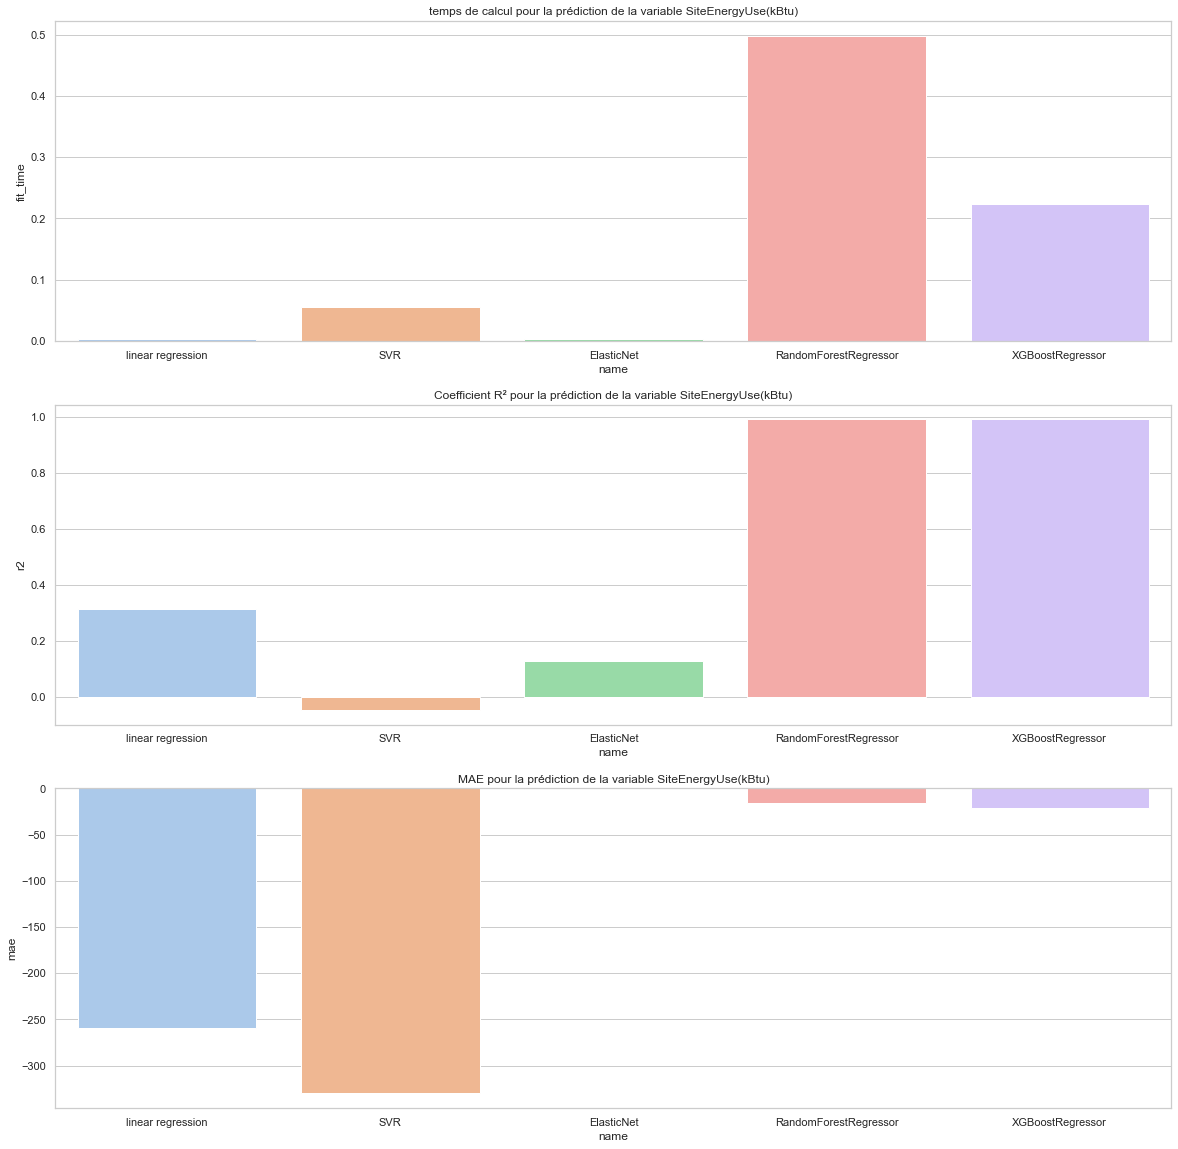

In [215]:
#Visualisation des différents modèles pour la variable TotalGHGEmissions

fig, axes = plt.subplots(nrows=3, ncols=1, sharex=False, sharey=False, figsize=(20,20))

sns.barplot(data=df_res_e, x="name", y="fit_time",ax =axes[0])
sns.barplot(data=df_res_e, x="name", y="r2",ax =axes[1])
sns.barplot(data=df_res_e, x="name", y="mae",ax =axes[2])


axes[0].set_title('temps de calcul pour la prédiction de la variable TotalGHGEmissions')
axes[1].set_title('Coefficient R² pour la prédiction de la variable TotalGHGEmissions')
axes[2].set_title('MAE pour la prédiction de la variable TotalGHGEmissions')

Text(0.5, 1.0, 'MAE pour la prédiction de la variable SiteEnergyUse(kBtu)')

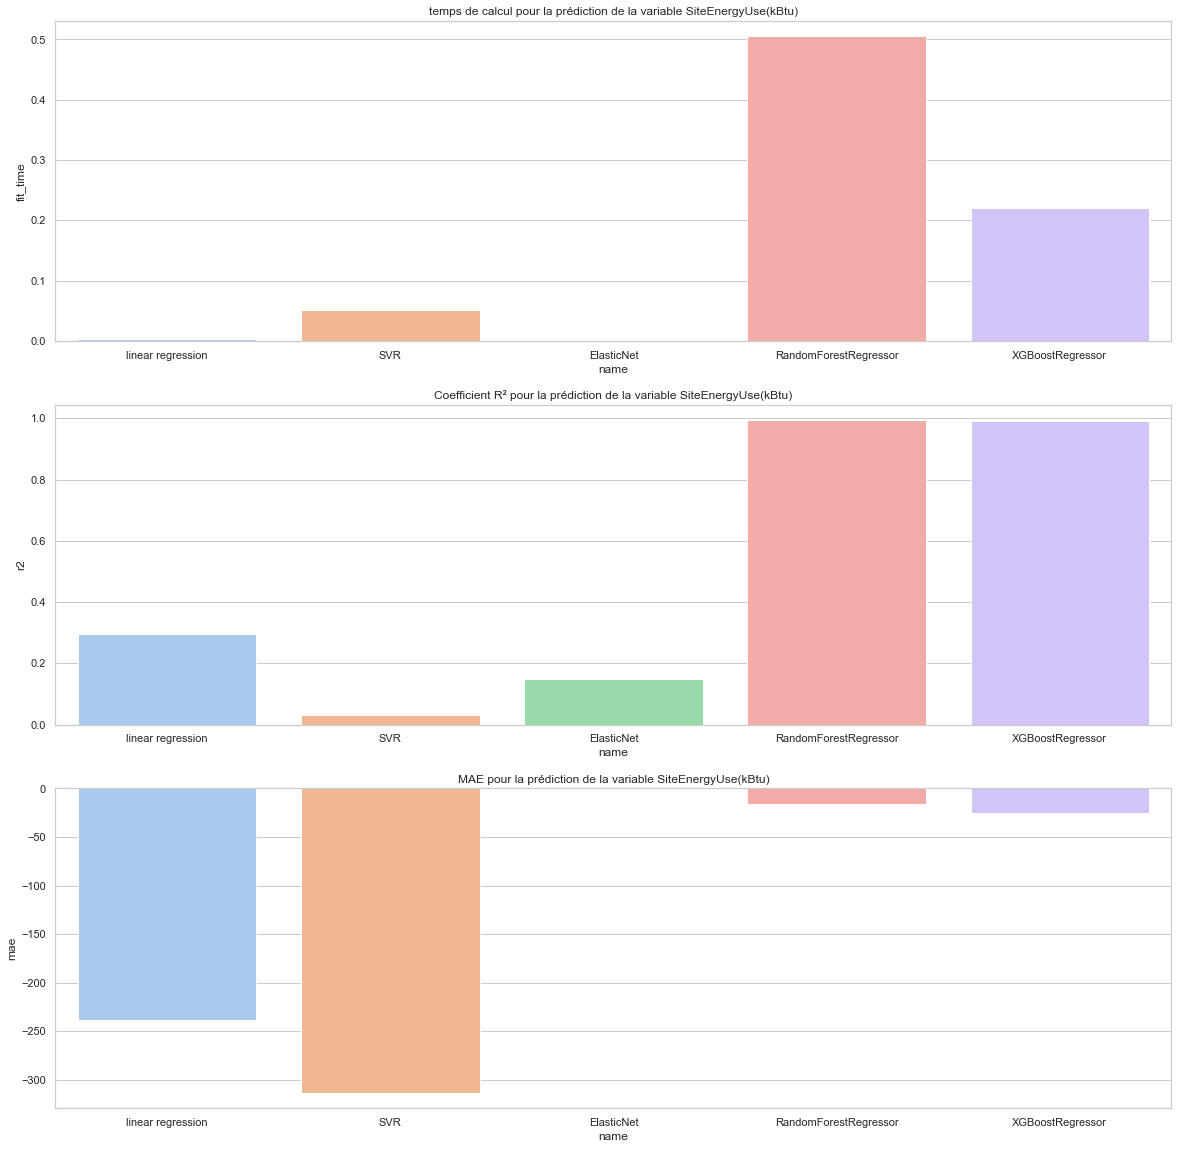

In [217]:
#Visualisation des différents modèles pour la variable SiteEnergyUse(kBtu)

fig, axes = plt.subplots(nrows=3, ncols=1, sharex=False, sharey=False, figsize=(20,20))

sns.barplot(data=df_res_C, x="name", y="fit_time",ax =axes[0])
sns.barplot(data=df_res_C, x="name", y="r2",ax =axes[1])
sns.barplot(data=df_res_C, x="name", y="mae",ax =axes[2])


axes[0].set_title('temps de calcul pour la prédiction de la variable SiteEnergyUse(kBtu)')
axes[1].set_title('Coefficient R² pour la prédiction de la variable SiteEnergyUse(kBtu)')
axes[2].set_title('MAE pour la prédiction de la variable SiteEnergyUse(kBtu)')

# Tuning hyperparamètres sur le modèle XGBoost retenu